In [18]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# matplotlib configuration
sns.set_style(style='ticks')
sns.set_theme(style="ticks")
sns.set(rc={'figure.figsize':(18,12)})

# pandas configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [25]:
raw_df = pd.read_csv('Airbnb_Open_Data.csv')
raw_df.rename(columns = dict(zip(raw_df.columns, [a.replace(' ', '_') for a in raw_df.columns])),inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<AxesSubplot:title={'center':'Missing values per column, %'}>

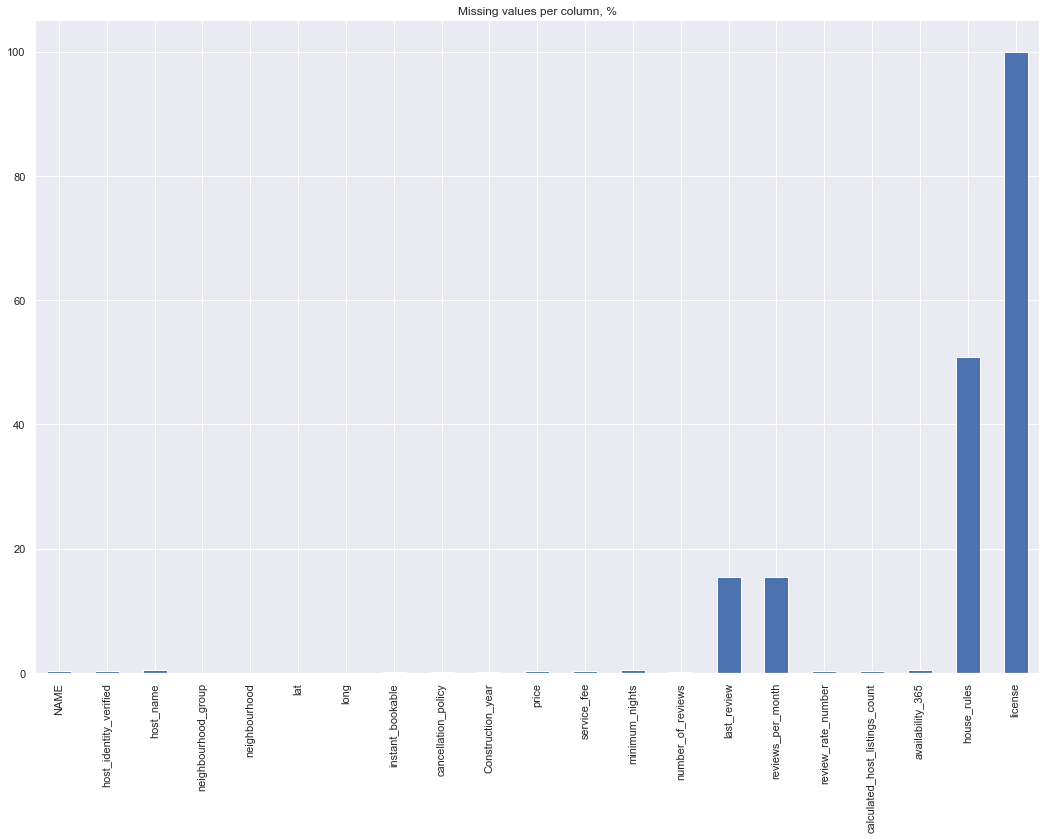

In [3]:
listings_missing = raw_df.isnull().mean()*100
listings_columns_with_nan = listings_missing[listings_missing > 0]
listings_columns_with_nan.plot.bar(title='Missing values per column, %')

#### ====================================================================================================

In [29]:
# defining directory of neighbourhood to neighbourhood groups
directory_dict = {}
for a, b in raw_df.groupby(['neighbourhood_group', 'neighbourhood']).count().index:
    directory_dict[b] = a
    
# defining target columns in removal of rows with null values in said columns
target_columns = raw_df.columns.to_list()
target_columns.remove('last_review')
target_columns.remove('reviews_per_month')
target_columns.remove('house_rules')
target_columns.remove('license')
# processed_df = processed_df[processed_df[target_columns].notnull().all(axis=1)].copy()

In [49]:
def tweak_df(df):
    return (df
            .rename(
                columns = dict(zip(df.columns, [a.replace(' ', '_') for a in df.columns]))
            )
            .assign(
                NAME = df.NAME.fillna('Unfilled Entry'),
                host_identity_verified = np.where(df['host_identity_verified'] == 'verified', True, False),
                host_name = df.host_name.fillna('unfilled'),
                last_review = pd.to_datetime(df.last_review, format='%m/%d/%Y', errors='coerce'),
                neighbourhood_group = df[['neighbourhood_group', 'neighbourhood']].apply(
                    ## this lambda function refers null 'neighbourhood_group' values to associated neighbourhood
                    lambda x : directory_dict[x.neighbourhood]
                    if (pd.isnull(x.neighbourhood_group))
                    else x.neighbourhood_group,
                    axis = 1
                ),
                price = df.price.replace({'\$': '', ' ':'', ',': ''}, regex=True),
                service_fee = df.service_fee.replace({'\$': '', ' ':'', ',': ''}, regex=True)
            )
            .astype({
                'lat': 'float32',
                'long': 'float32',
                'host_identity_verified': 'boolean',
                'instant_bookable': 'boolean',
                'cancellation_policy': 'category',
                'room_type': 'category',
                'price': 'float32',
                'service_fee': 'float32'
            })
    ).drop(
        columns = 'license',
    ).dropna(subset=target_columns)

# original memory usage = 106568597
tweak_df(raw_df).shape
# tweak_df(raw_df).isna().sum()
# tweak_df(raw_df).memory_usage(deep=True).sum()

(100347, 23)

In [40]:
# def tweak_df(df):
#     return (df
#             .rename(
#                 columns = dict(zip(df.columns, [a.replace(' ', '_') for a in df.columns]))
#             )
#             .assign(
#                 NAME = df.NAME.fillna('Unfilled Entry'),
#                 host_identity_verified = np.where(df['host_identity_verified'] == 'verified', True, False),
#                 host_name = df.host_name.fillna('unfilled'),
#                 last_review = pd.to_datetime(df.last_review, format='%m/%d/%Y', errors='coerce'),
#                 neighbourhood_group = df[['neighbourhood_group', 'neighbourhood']].apply(
#                     ## this lambda function refers null 'neighbourhood_group' values to associated neighbourhood
#                     lambda x : directory_dict[x.neighbourhood]
#                     if (pd.isnull(x.neighbourhood_group))
#                     else x.neighbourhood_group,
#                     axis = 1
#                 ),
#                 price = df.price.replace({'\$': '', ' ':'', ',': ''}, regex=True),
#                 service_fee = df.service_fee.replace({'\$': '', ' ':'', ',': ''}, regex=True)
#             )
#             .astype({
#                 'lat': 'float32',
#                 'long': 'float32',
#                 'host_identity_verified': 'boolean',
#                 'instant_bookable': 'boolean',
#                 'cancellation_policy': 'category',
#                 'room_type': 'category',
#                 'price': 'float32',
#                 'service_fee': 'float32'
#             })
#     ).drop(
#         columns = 'license',
#     )[df[target_columns].notnull().all(axis=1)]

# # original memory usage = 106568597
# tweak_df(raw_df).shape
# # tweak_df(raw_df).isna().sum()
# # tweak_df(raw_df).memory_usage(deep=True).sum()

(99502, 23)

In [50]:
df = tweak_df(raw_df)

#### ====================================================================================================

### Further cleaning of processed date, addressing outliers / standardising ranges of data

In [51]:
# further cleaning processed data, dropping unwanted rows
df.drop(df[df.neighbourhood_group == 'brookln'].index, inplace=True)

In [52]:
qual_cols = ['NAME', 'host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood',
            'instant_bookable', 'cancellation_policy', 'room_type', 'house_rules']
quan_cols = ['lat', 'long', 'price', 'service_fee', 'minimum_nights', 
                'number_of_reviews', 'Construction_year', 'review_rate_number', 
                'calculated_host_listings_count', 'availability_365']

In [53]:
# check for outliers, typos in qualitative columns
print('Number of unique values for associating columns', '\n===============================================')
for each in qual_cols:
    if df[each].nunique() > 10: print(each, ': ', df[each].nunique())
    else: print(each, ': ', df[each].explode().unique())

Number of unique values for associating columns 
NAME :  60069
host_identity_verified :  <BooleanArray>
[False, True]
Length: 2, dtype: boolean
host_name :  13079
neighbourhood_group :  ['Brooklyn' 'Manhattan' 'Staten Island' 'Bronx' 'Queens']
neighbourhood :  224
instant_bookable :  <BooleanArray>
[False, True]
Length: 2, dtype: boolean
cancellation_policy :  ['strict', 'moderate', 'flexible']
Categories (3, object): ['strict', 'moderate', 'flexible']
room_type :  ['Private room', 'Entire home/apt', 'Shared room', 'Hotel room']
Categories (4, object): ['Private room', 'Entire home/apt', 'Shared room', 'Hotel room']
house_rules :  1975


##### Observation: Qualitative data is mostly validated with no inconsistent outliers

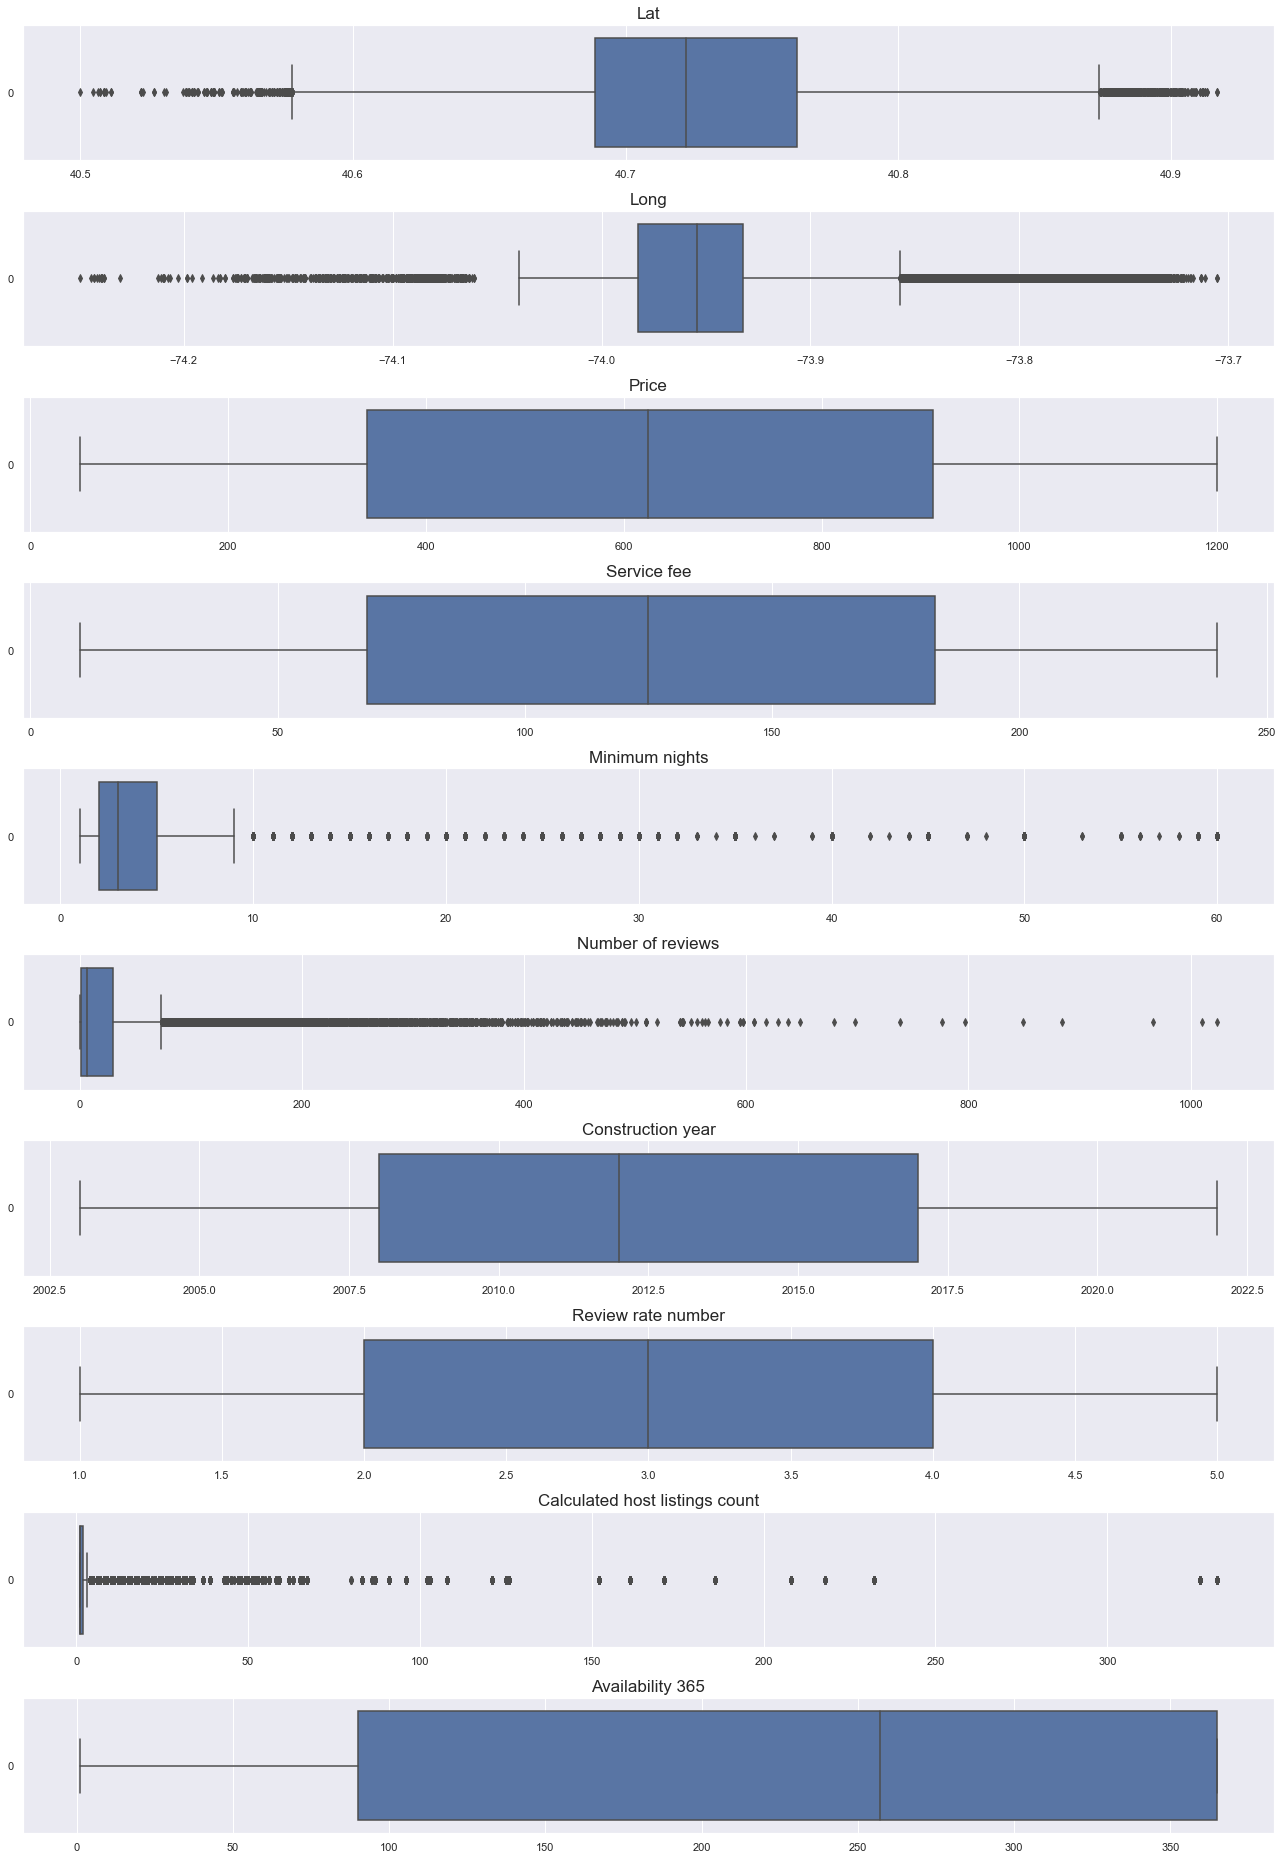

In [56]:
# check for outliers in quantitative data
f, ax = plt.subplots(len(quan_cols), 1, figsize= (18, 26))
def chart_boxplot(data_input, ax_input):
    sns.boxplot(
        data = df[data_input],
        orient='h',
        ax = ax_input
    )
    try: ax_input.set_title(data_input.capitalize().replace('_', ' '), fontsize = 17)
    except AttributeError: ax_input.set_title(data_input, fontsize = 17)

for each in range(0, len(quan_cols)):
    chart_boxplot(quan_cols[each], ax[each])
    
plt.tight_layout()
plt.show()

##### Observation: 
##### lat, long, price, service fee, construction year, review rate number: No notable issues
##### calculated host listings, number of reviews: large variance which falls under natural observation
##### minimum nights: notable outliers along with negative values
##### availability 365: one significant outlier / entry should be capped at 365 days of year / contains negative values

In [55]:
## addressing / normalising outliers and data range

df.availability_365 = df.availability_365.apply(lambda x: 365 if (x > 365) | (x < 1) else x)

def reset_minimum_nights(input):
    if input < 0:
        return 1
    elif input > 60:
        return 60
    else: return input
    
df.minimum_nights = df.minimum_nights.apply(lambda x: reset_minimum_nights(x))

### Issue: Inconsistency between Availability_365 and Minimum_nights

In [12]:
# current solution is to remove the invalid rows entirely since it does not take up a large portion of the dataset 
# 1,515 / 99,501 = 1.5% of the current data set

df[~(df.minimum_nights > df.availability_365)].to_csv('cleaned_airbnb_data.csv')